# AC-GAN in Keras

*@masahiro rikiso, 170305*

* arxiv: https://arxiv.org/abs/1610.09585
* implementation reference: https://github.com/lukedeo/keras-acgan/blob/master/mnist_acgan.py

In [1]:
from __future__ import print_function
import numpy as np
from collections import defaultdict
import cPickle as pickle
from PIL import Image

from six.moves import range
np.random.seed(1337)

## load dataset

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

nb_train, nb_test = X_train.shape[0], X_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

In [4]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, merge, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar

In [28]:
def generator(z_size):
    z = Input(shape=(100,))
    c = Input(shape=(10,))
    
    h = merge([z, c], mode='concat')
    
    model = Sequential()

    model.add(Dense(1024, input_dim=110, activation='relu'))
    model.add(Dense(128 * 7 * 7, activation='relu'))
    model.add(Reshape((7, 7, 128)))

    # upsample to (..., 14, 14)
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(256, 5, 5, border_mode='same', activation='relu'))
    
    # upsample to (..., 28, 28)
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu'))

    model.add(Convolution2D(1, 2, 2, border_mode='same', activation='tanh'))

    x = model(h)
    
    return Model(input=[z, c], output=x), model

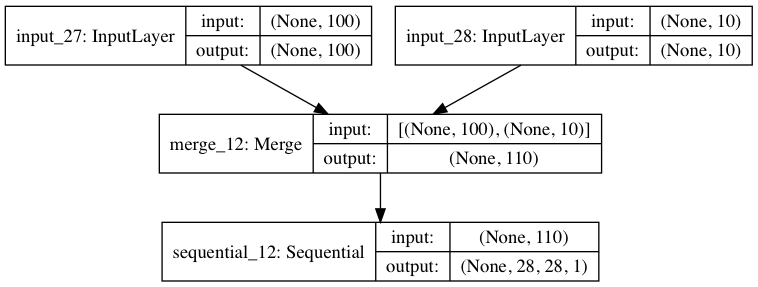

In [30]:
G, seq = generator(100)

from keras.utils.visualize_util import plot
plot(G, to_file="model_acgan_G.png", show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image("model_acgan_G.png")

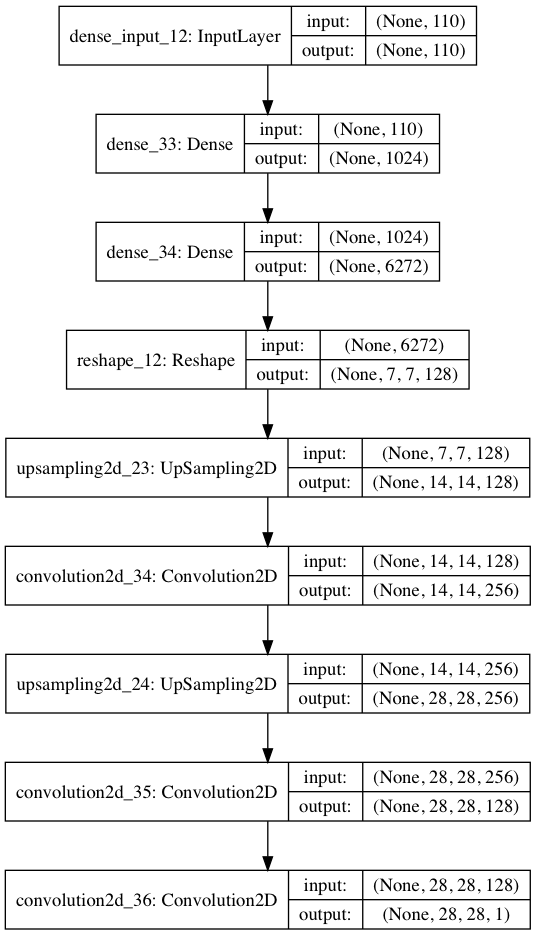

In [31]:
G, seq = generator(100)

from keras.utils.visualize_util import plot
plot(seq, to_file="model_acgan_G.png", show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image("model_acgan_G.png")

In [36]:
def discriminator():
    image = Input(shape=(28, 28, 1))
    
    model = Sequential()

    #(1,28,28)to(32,14,14)
    model.add(Convolution2D(32, 3, 3, border_mode='same', subsample=(2, 2),
                          input_shape=(28, 28, 1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #(32,14,14)to(64,14,14)
    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #(64,14,14)to(128,7,7)
    model.add(Convolution2D(128, 3, 3, border_mode='same', subsample=(2, 2)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #(128,7,7)to(256,7,7)
    model.add(Convolution2D(256, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())

    features = model(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(10, activation='softmax', name='auxiliary')(features)

    return Model(input=image, output=[fake, aux]), model

In [42]:
D, seq = discriminator()

from keras.utils.visualize_util import plot
plot(D, to_file="model_acgan_D1.png", show_shapes=True, show_layer_names=True)
plot(seq, to_file="model_acgan_D2.png", show_shapes=True, show_layer_names=True)

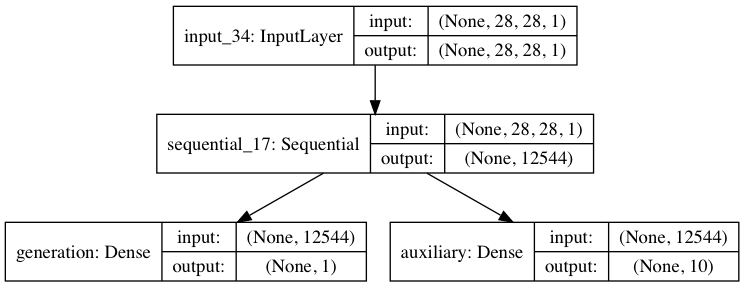

In [48]:
from IPython.display import Image
Image("model_acgan_D1.png", width=500)

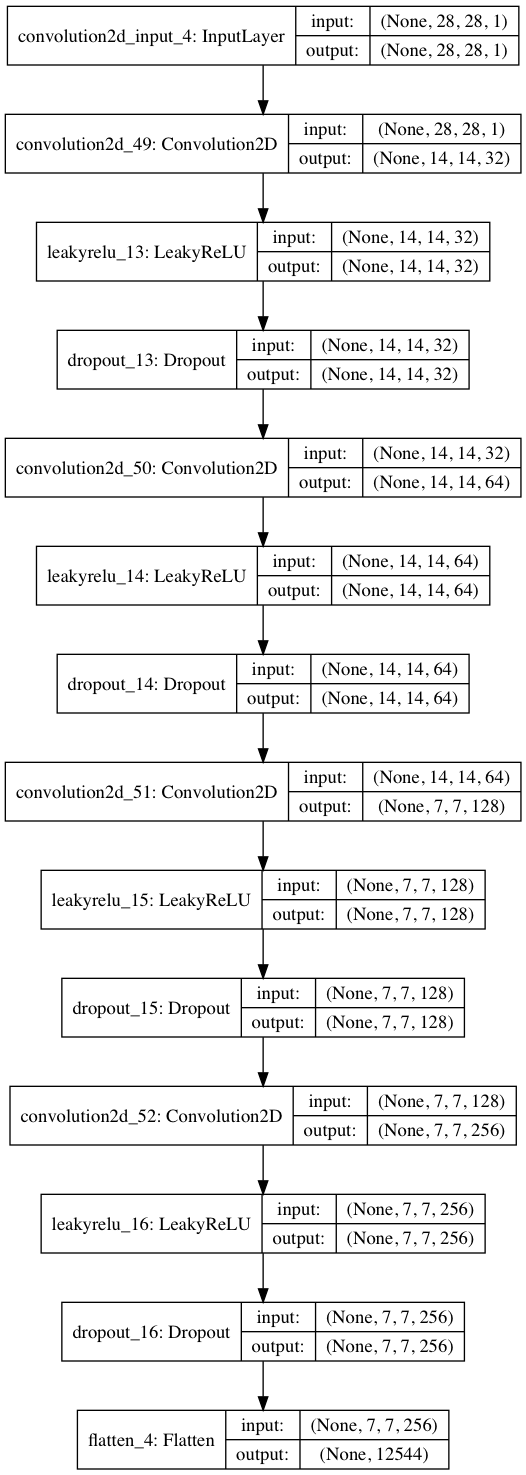

In [47]:
from IPython.display import Image
Image("model_acgan_D2.png", width=300)

In [ ]:
# batch and latent size taken from the paper
nb_epochs = 50
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# build the generator
generator = build_generator(latent_size)
generator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                  loss='binary_crossentropy')

latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model(input=[latent, image_class], output=[fake, aux])

combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)



for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(epoch + 1, nb_epochs))

    nb_batches = int(X_train.shape[0] / batch_size)
    progress_bar = Progbar(target=nb_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(nb_batches):
        progress_bar.update(index)
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (batch_size, latent_size))

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, 10, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
        sampled_labels = np.random.randint(0, 10, 2 * batch_size)

        # we want to train the genrator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

    print('\nTesting for epoch {}:'.format(epoch + 1))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (nb_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, 10, nb_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        X, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * nb_test, latent_size))
    sampled_labels = np.random.randint(0, 10, 2 * nb_test)

    trick = np.ones(2 * nb_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    discriminator.save_weights(
        'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

    # generate some digits to display
    noise = np.random.uniform(-1, 1, (100, latent_size))

    sampled_labels = np.array([
        [i] * 10 for i in range(10)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 28)
                           for r in np.split(generated_images, 10)
                           ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

    Image.fromarray(img).save(
        'plot_epoch_{0:03d}_generated.png'.format(epoch))

pickle.dump({'train': train_history, 'test': test_history},
            open('acgan-history.pkl', 'wb'))

## define NN architecture

In [6]:
import numpy as np

from keras.optimizers import Adam
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers import Input, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.utils import generic_utils
import keras.backend as K

In [7]:
def generator_upsampling(cat_dim, cont_dim, noise_dim):
    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    gen_input = merge([cat_input, cont_input, noise_input], mode="concat")

    x = Dense(1024)(gen_input)
    x = BatchNormalization(mode=1)(x)
    x = Activation("relu")(x)

    x = Dense(7*7*128)(x)
    x = BatchNormalization(mode=1)(x)
    x = Activation("relu")(x)

    x = Reshape((7,7,128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(64, 3, 3, border_mode="same")(x)
    x = BatchNormalization(mode=2, axis=-1)(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(32, 3, 3, border_mode="same")(x)
    x = BatchNormalization(mode=2, axis=-1)(x)
    x = Activation("relu")(x)

    x = Convolution2D(1, 3, 3, name="gen_convolution2d_final", border_mode="same", activation='tanh')(x)

    generator_model = Model(input=[cat_input, cont_input, noise_input], output=[x], name="generator_upsampling")
    
    return generator_model

In [8]:
def discriminator(cat_dim, cont_dim):
    disc_input = Input(shape=(28,28,1), name="discriminator_input")

    x = Convolution2D(64, 3, 3, subsample=(2, 2), name="disc_convolution2d_1", border_mode="same")(disc_input)
    x = LeakyReLU(0.2)(x)

    x = Convolution2D(128, 3, 3, subsample=(2, 2), name="disc_convolution2d_2", border_mode="same")(x)
    x = BatchNormalization(mode=2, axis=-1)(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = BatchNormalization(mode=1)(x)
    x = LeakyReLU(0.2)(x)

    def linmax(x):
        return K.maximum(x, -16)

    def linmax_shape(input_shape):
        return input_shape

    # More processing for auxiliary Q
    x_Q = Dense(128)(x)
    x_Q = BatchNormalization(mode=1)(x_Q)
    x_Q = LeakyReLU(0.2)(x_Q)
    x_Q_Y = Dense(cat_dim[0], activation='softmax', name="Q_cat_out")(x_Q)
    x_Q_C_mean = Dense(cont_dim[0], activation='linear', name="dense_Q_cont_mean")(x_Q)
    x_Q_C_logstd = Dense(cont_dim[0], name="dense_Q_cont_logstd")(x_Q)
    x_Q_C_logstd = Lambda(linmax, output_shape=linmax_shape)(x_Q_C_logstd)

    x_Q_C_mean = Reshape((1, cont_dim[0]))(x_Q_C_mean)
    x_Q_C_logstd = Reshape((1, cont_dim[0]))(x_Q_C_logstd)
    x_Q_C = merge([x_Q_C_mean, x_Q_C_logstd], mode="concat", name="Q_cont_out", concat_axis=1)

    # Create discriminator model
    x_disc = Dense(2, activation='softmax', name="disc_out")(x)
    discriminator_model = Model(input=[disc_input], output=[x_disc, x_Q_Y, x_Q_C], name="DCGAN_discriminator")

    return discriminator_model

In [9]:
def DCGAN(generator, discriminator_model, cat_dim, cont_dim, noise_dim):

    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    generated_image = generator([cat_input, cont_input, noise_input])
    x_disc, x_Q_Y, x_Q_C = discriminator_model(generated_image)

    DCGAN = Model(input=[cat_input, cont_input, noise_input],
                  output=[x_disc, x_Q_Y, x_Q_C],
                  name="DCGAN")

    return DCGAN

## define utility functions to get training batch

In [10]:
def gen_batch(X, batch_size):

    while True:
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
        yield X[idx]

In [11]:
def sample_noise(noise_scale, batch_size, noise_dim):

    return np.random.normal(scale=noise_scale, size=(batch_size, noise_dim[0]))


def sample_cat(batch_size, cat_dim):

    y = np.zeros((batch_size, cat_dim[0]), dtype='float32')
    random_y = np.random.randint(0, cat_dim[0], size=batch_size)
    y[np.arange(batch_size), random_y] = 1

    return y

def get_disc_batch(X_real_batch, generator_model, batch_counter, batch_size, cat_dim, cont_dim, noise_dim,
                   noise_scale=0.5, label_smoothing=False):

    # Create X_disc: alternatively only generated or real images
    if batch_counter % 2 == 0:
        # Pass noise to the generator
        y_cat = sample_cat(batch_size, cat_dim)
        y_cont = sample_noise(noise_scale, batch_size, cont_dim)
        noise_input = sample_noise(noise_scale, batch_size, noise_dim)
        # Produce an output
        X_disc = generator_model.predict([y_cat, y_cont, noise_input])
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_disc[:, 0] = 1

    else:
        X_disc = X_real_batch
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_cat = sample_cat(batch_size, cat_dim)
        y_cont = sample_noise(noise_scale, batch_size, cont_dim)
        if label_smoothing:
            y_disc[:, 1] = np.random.uniform(low=0.9, high=1, size=y_disc.shape[0])
        else:
            y_disc[:, 1] = 1

    # Repeat y_cont to accomodate for keras' loss function conventions
    y_cont = np.expand_dims(y_cont, 1)
    y_cont = np.repeat(y_cont, 2, axis=1)

    return X_disc, y_disc, y_cat, y_cont

In [12]:
def get_gen_batch(batch_size, cat_dim, cont_dim, noise_dim, noise_scale=0.5):

    X_gen = sample_noise(noise_scale, batch_size, noise_dim)
    y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
    y_gen[:, 1] = 1

    y_cat = sample_cat(batch_size, cat_dim)
    y_cont = sample_noise(noise_scale, batch_size, cont_dim)

    # Repeat y_cont to accomodate for keras' loss function conventions
    y_cont_target = np.expand_dims(y_cont, 1)
    y_cont_target = np.repeat(y_cont_target, 2, axis=1)

    return X_gen, y_gen, y_cat, y_cont, y_cont_target

## training

In [13]:
def gaussian_loss(y_true, y_pred):

    Q_C_mean = y_pred[:, 0, :]
    Q_C_logstd = y_pred[:, 1, :]

    y_true = y_true[:, 0, :]

    epsilon = (y_true - Q_C_mean) / (K.exp(Q_C_logstd) + K.epsilon())
    loss_Q_C = (Q_C_logstd + 0.5 * K.square(epsilon))
    loss_Q_C = K.mean(loss_Q_C)

    return loss_Q_C

In [14]:
cat_dim = (10,)
cont_dim = (2,)
noise_dim = (64,)

In [15]:
opt_dcgan = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
opt_discriminator = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)

generator_model = generator_upsampling(cat_dim, cont_dim, noise_dim)
discriminator_model = discriminator(cat_dim, cont_dim)

generator_model.compile(loss='mse', optimizer=opt_discriminator)
discriminator_model.trainable = False
DCGAN_model = DCGAN(generator_model, discriminator_model, cat_dim, cont_dim, noise_dim)

list_losses = ['binary_crossentropy', 'categorical_crossentropy', gaussian_loss]
list_weights = [1, 1, 1]
DCGAN_model.compile(loss=list_losses, loss_weights=list_weights, optimizer=opt_dcgan)

# Multiple discriminator losses
discriminator_model.trainable = True
discriminator_model.compile(loss=list_losses, loss_weights=list_weights, optimizer=opt_discriminator)

gen_loss = 100
disc_loss = 100

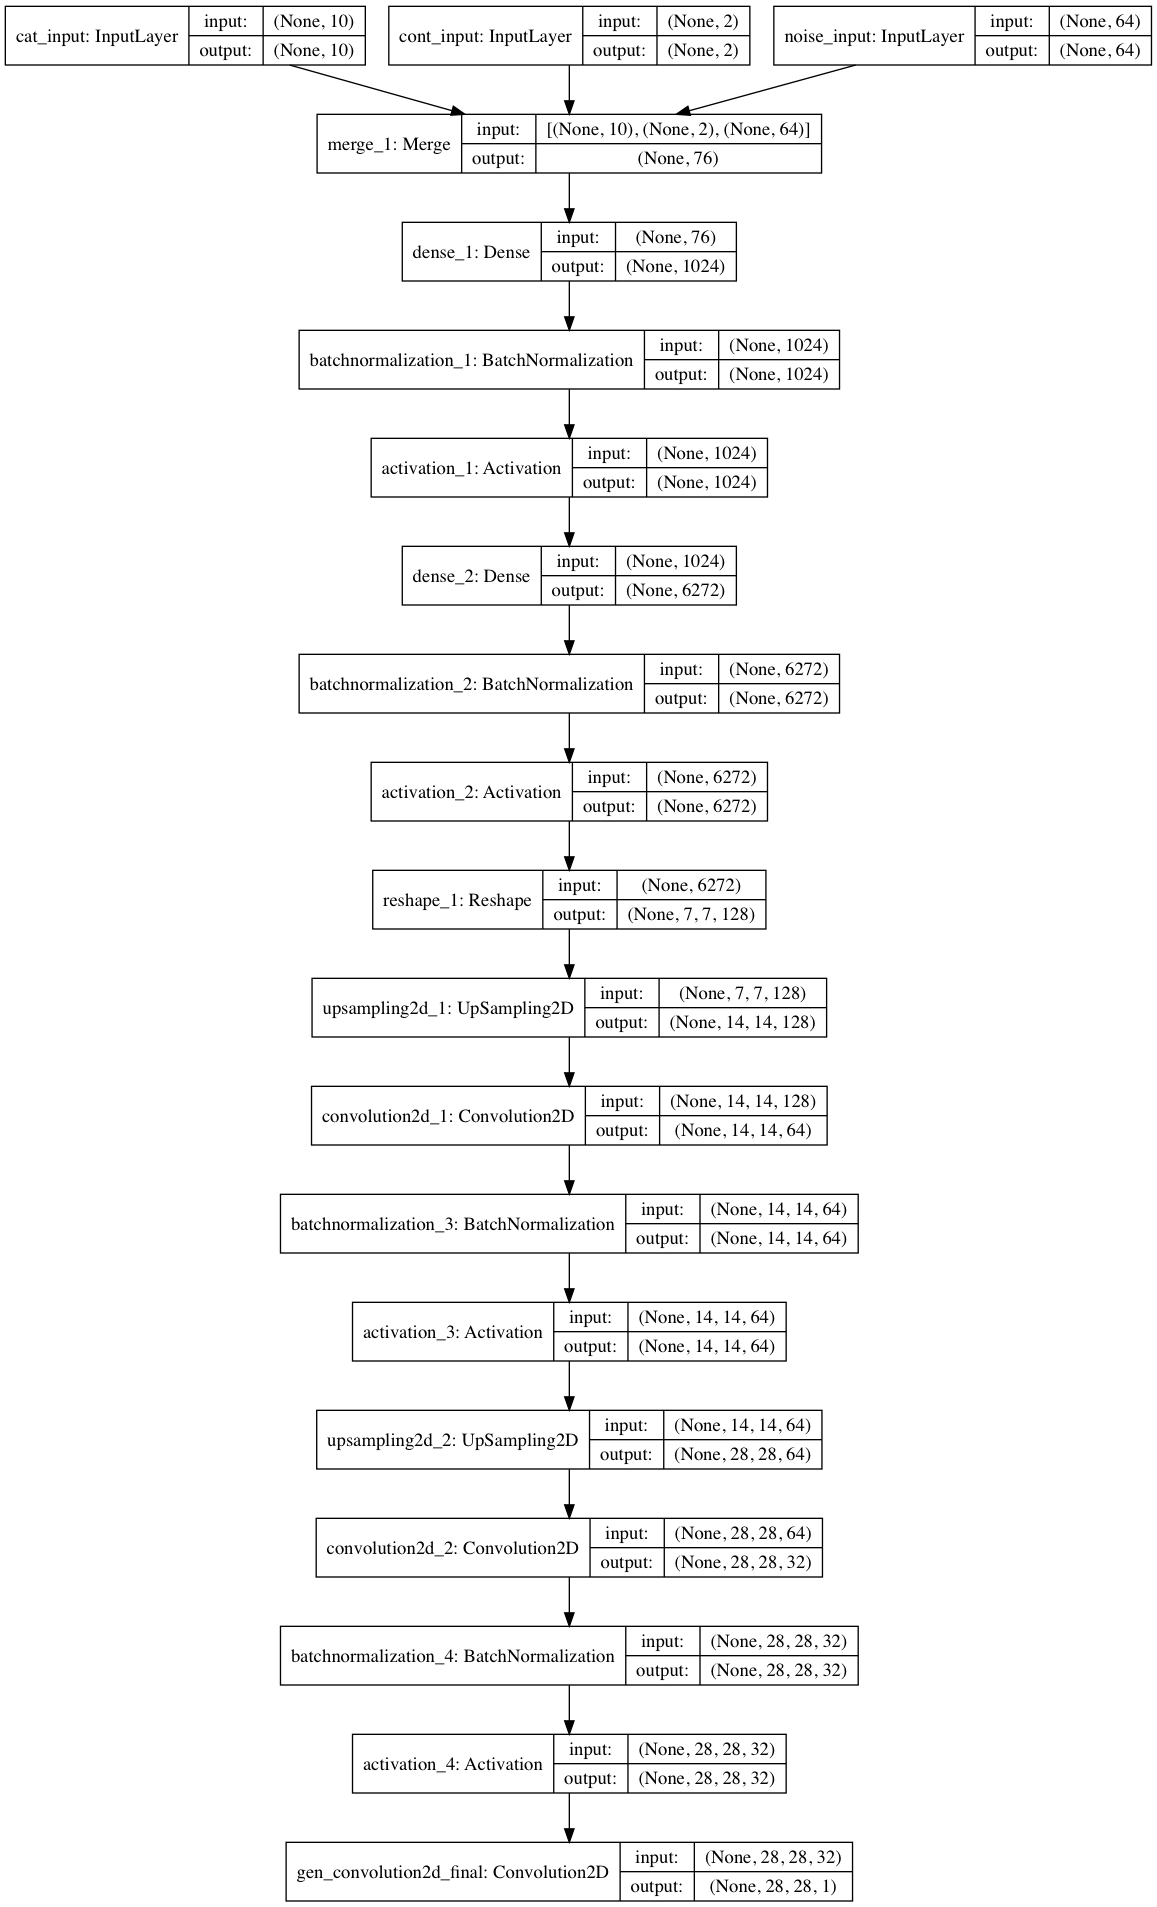

In [18]:
from keras.utils.visualize_util import plot
plot(generator_model, to_file="fig/infogan_G.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("fig/infogan_G.png")#, width=500)

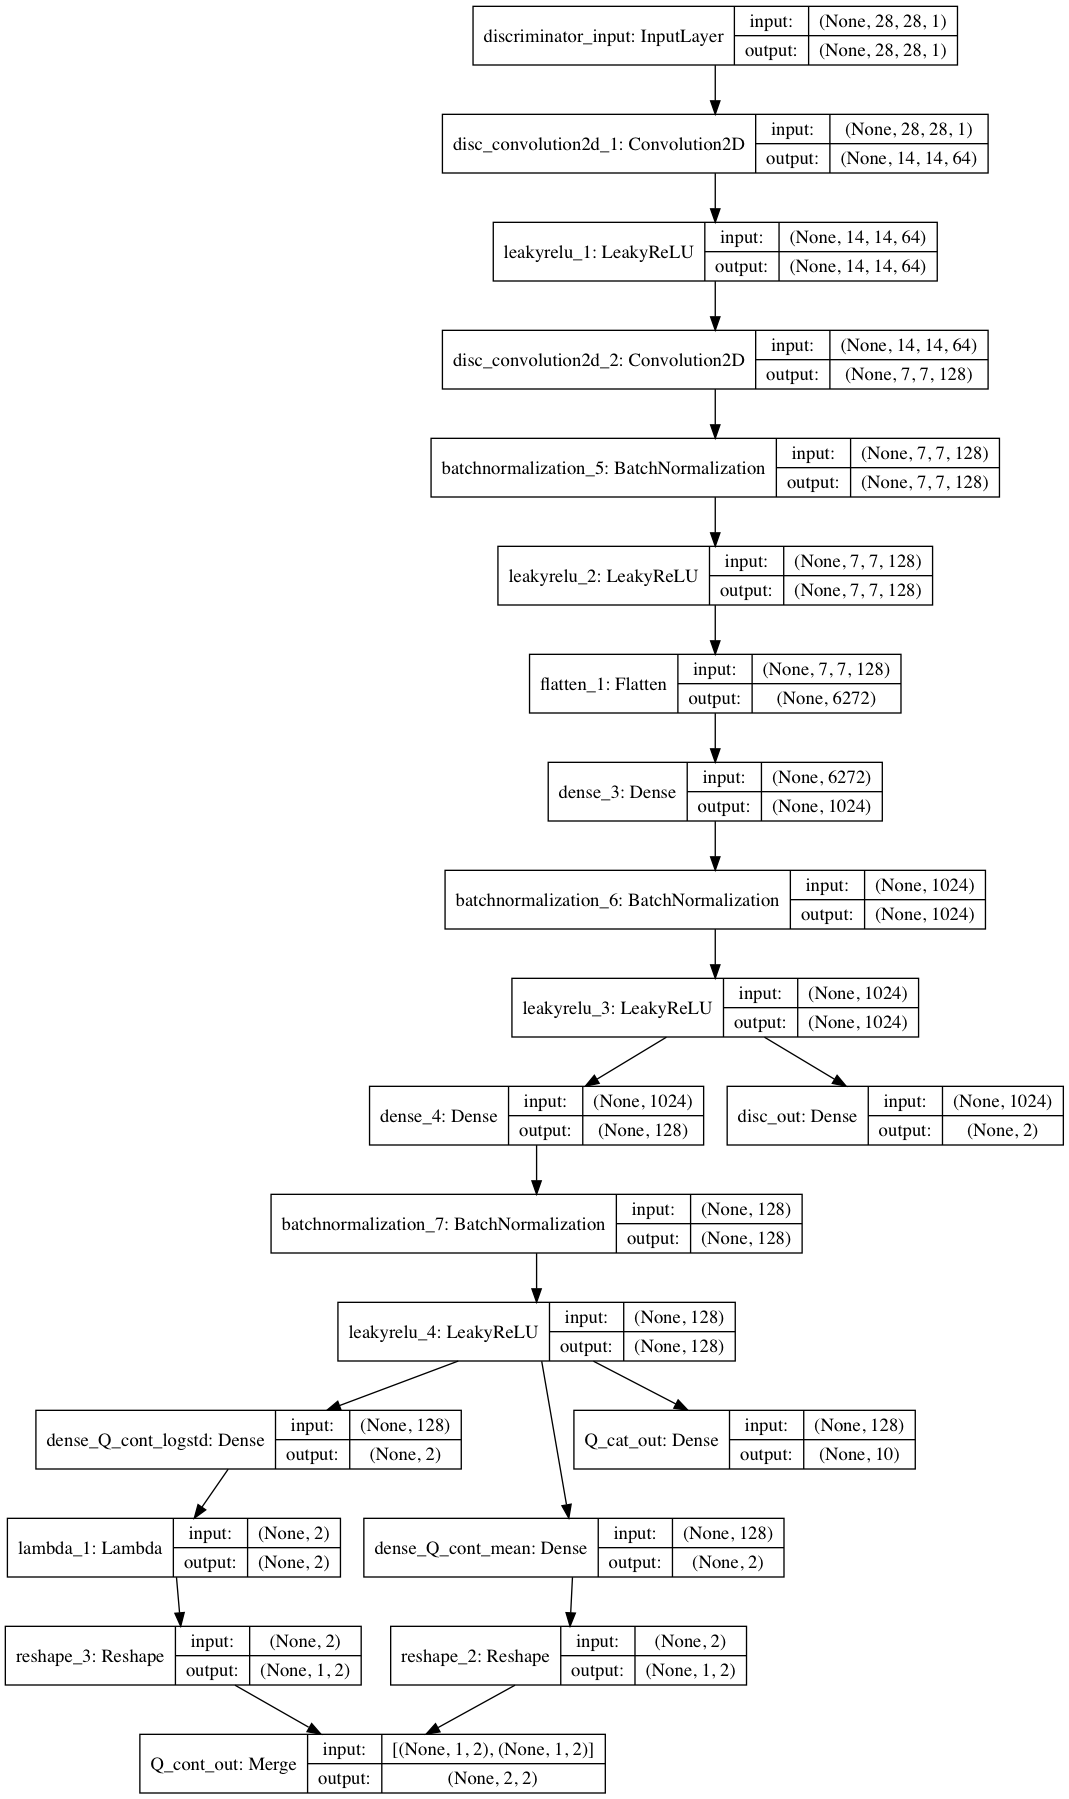

In [19]:
from keras.utils.visualize_util import plot
plot(discriminator_model, to_file="fig/infogan_D.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("fig/infogan_D.png")#, width=500)

In [14]:
nb_epoch = 400
n_batch_per_epoch = 2000
batch_size = 32
epoch_size = n_batch_per_epoch * batch_size

# Start training
print("Start training")
for e in range(nb_epoch):
    # Initialize progbar and batch counter
    progbar = generic_utils.Progbar(epoch_size)
    batch_counter = 1

    for X_real_batch in gen_batch(X_train, batch_size):

        # Create a batch to feed the discriminator model
        X_disc, y_disc, y_cat, y_cont = get_disc_batch(X_real_batch,
                                                      generator_model,
                                                      batch_counter,
                                                      batch_size,
                                                      cat_dim,
                                                      cont_dim,
                                                      noise_dim,
                                                      noise_scale=0.5,
                                                      label_smoothing=True)

        # Update the discriminator
        disc_loss = discriminator_model.train_on_batch(X_disc, [y_disc, y_cat, y_cont])

        # Create a batch to feed the generator model
        X_gen, y_gen, y_cat, y_cont, y_cont_target = get_gen_batch(batch_size,
                                                                  cat_dim,
                                                                  cont_dim,
                                                                  noise_dim,
                                                                  noise_scale=0.5)

        # Freeze the discriminator
        discriminator_model.trainable = False
        gen_loss = DCGAN_model.train_on_batch([y_cat, y_cont, X_gen], [y_gen, y_cat, y_cont_target])
        # Unfreeze the discriminator
        discriminator_model.trainable = True

        batch_counter += 1
        progbar.add(batch_size, values=[("D tot", disc_loss[0]),
                                        ("D log", disc_loss[1]),
                                        ("D cat", disc_loss[2]),
                                        ("D cont", disc_loss[3]),
                                        ("G tot", gen_loss[0]),
                                        ("G log", gen_loss[1]),
                                        ("G cat", gen_loss[2]),
                                        ("G cont", gen_loss[3])])

        if batch_counter >= n_batch_per_epoch:
            break


Start training
  576/64000 [..............................] - ETA: 2697s - D tot: 11.5748 - D log: 1.4288 - D cat: 2.4865 - D cont: 7.6595 - G tot: 5.4886 - G log: 2.2195 - G cat: 2.4034 - G cont: 0.8657 

KeyboardInterrupt: 